# Download full ecodices

In [1]:
import pandas as pd
import requests
import shutil
import json
import time
from tqdm import tqdm

In [2]:
import torch
import torch.utils.data
import torchvision
from glob import glob
import json
import os
from pathlib import Path
import random
from PIL import Image
from zipfile import ZipFile
import torchvision.transforms as transforms

import numpy as np

In [3]:
import os
from pathlib import Path

config = json.load(open(os.path.expanduser("~/.thesis.conf")))
db_folder = Path(config['datasets']) / Path("codices_all/") 
db_folder.mkdir(exist_ok=True)
# os.chdir(str(db_folder))

In [8]:
class ECodices(torch.utils.data.Dataset):
    # HisDB name -> id
    codices = {'CS18' : 'csg-0018',
               'CS863': 'csg-0863',
               'CB55' : 'fmb-cb-0055'}
    iiifurl = 'http://www.e-codices.unifr.ch/metadata/iiif/{}/manifest.json'
    hisdbformat = 'e-codices_{}_max.jpg'
    
    def load_manifests(self, path, codices):
        for name, webid in codices:    
            manifest_file   = path / Path(webid + '.json')
            manifest = json.load(manifest_file.open())

            # load canvas table
            canvases = pd.DataFrame(manifest['sequences'][0]['canvases'])
            canvases['jpeg'] = [c[0]['resource']['@id'] for c in canvases['images']]
            canvases['set']  = name
            yield canvases

    def download(url, path):
        response = requests.get(url, stream=True)
        with path.open('wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        del response

    def download_images(self, path, canvases, pause=2, filtered=True):
            # download images
            for canvas in tqdm(canvases.itertuples()):
                if not canvas.file.exists():
#                     download(canvas.jpeg, file)
                    print(file)
                    time.sleep(pause)
                    
    def __init__(self, path, download=False, label_regex='\d+'):
        self.path = path
        if download:
            # download manifest
            for name, webid in self.codices.items(): 
                manifest_file   = path / Path(webid + '.json')
                manifest_url = self.iiifurl.format(webid)
                os.makedirs(str(path / name / 'img' / 'training'), exist_ok=True)
                if not manifest_file.exists():
                    resp         = requests.get(manifest_url)
                    manifest     = json.loads(resp.content)
                    json.dump(manifest, manifest_file.open(mode='w'))
        
        
        self.allcanvases = pd.concat(self.load_manifests(path, self.codices.items()))
        self.allcanvases['file'] = [path / row.set / 'img' / 'training' / Path(self.hisdbformat.format(Path(row._1).stem)) for row in self.allcanvases.itertuples()]
        self.allcanvases = self.allcanvases[self.allcanvases.label.str.contains('\d+')]
        if download:
            self.download_images(path, self.allcanvases)
            
#         self.paths = glob(str(path / '*' / 'img' / 'training' / '*.jpg'))
        
        
    def __len__(self):
        return len(self.allcanvases)

    def __getitem__(self, index):
        assert index < len(self)
        imgpath = self.allcanvases['file'].iloc[index]
        img =  Image.open(imgpath)
        return img

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
dataset = ECodices(db_folder, download=True)

798it [00:00, 41965.65it/s]


In [126]:
# dataset.allcanvases[dataset.allcanvases.label.str.contains('\d+')]

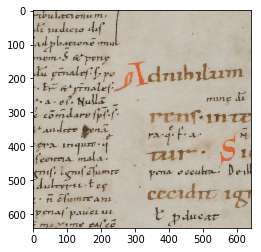

In [12]:
i = 100
xpos, ypos, size = 500,700, 640
box = (xpos,ypos,xpos+size,ypos+size)
img = dataset[i].crop(box)
plt.imshow(img)
img.save('../../doc/figures/datasets/path_'+ dataset.allcanvases.file.iloc[i].name)